# Cuối kì - **Xử lý dữ liệu lớn** - 504048

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Thành viên nhóm:

*   Nguyễn Quốc Anh     - **52100871**
*   Võ Phú Vinh         - **52100947**
*   Lục Minh Hiếu       - **52100889**
*   Nguyễn Vũ Tường     - **52100944**




## Cài đặt môi trường PySpark

### Copy file cài đặt PySpark

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!cp drive/MyDrive/TĐT/MMDS/spark-3.1.1-bin-hadoop3.2.tgz .
!cp drive/MyDrive/TĐT/MMDS/FinalDatasets/*.csv .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

### Cấu hình biến môi trường cho Spark

In [ ]:
import os
import findspark
import matplotlib.pyplot as plt

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

findspark.init()

In [ ]:
import pyspark

print(pyspark.__version__)

3.1.1


### Tạo Spark Session

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

# Initialize SparkSession
sparkSession = SparkSession.builder \
    .appName("Final Term") \
    .getOrCreate()

## Câu 1: Phân cụm dữ liệu

### Đọc dữ liệu từ ***mnist_mini.csv***

In [ ]:
# Define the structure for the data frame
column_names = [T.StructField('Label', T.ByteType(), True)] + \
               [
                T.StructField(f'Pixel_{i}', T.ShortType(), True)\
                for i in range(784)
               ]

mnist_schema = T.StructType(column_names)

# Load data from file with schema created
mnist_df = sparkSession.read.csv("/content/mnist_mini.csv", schema=mnist_schema)

# Show first few rows
mnist_df.show(5)

## Câu 2: Giảm số chiều với SVD

## Câu 3: Khuyến nghị sản phẩm với Collaborative Filtering

### Đọc dữ liệu từ ***ratings2k.csv***

In [ ]:
# Define the structure for the data frame
ratings2k_schema = T.StructType([
    T.StructField('index', T.ShortType(), True),
    T.StructField('user', T.ShortType(), True),
    T.StructField('item', T.ShortType(), True),
    T.StructField('rating', T.DecimalType(2, 1), True),
])

# Load data from file with schema created
ratings2k_df = sparkSession.read.csv("/content/ratings2k.csv",
                                     schema = ratings2k_schema,
                                     header = True
                                    )

# Show DataFrame schema and first few rows
ratings2k_df.printSchema()
ratings2k_df.show(5)

root
 |-- index: short (nullable = true)
 |-- user: short (nullable = true)
 |-- item: short (nullable = true)
 |-- rating: decimal(2,1) (nullable = true)

+-----+----+----+------+
|index|user|item|rating|
+-----+----+----+------+
|    0|  73|  52|   4.0|
|    1|  36| 239|   3.0|
|    2|  72|  26|   1.0|
|    3|  59| 430|   2.5|
|    4|  72| 284|   3.0|
+-----+----+----+------+
only showing top 5 rows



## Câu 4: Dự đoán giá chứng khoán

In [ ]:
from pyspark.sql import Window
from pyspark.ml.regression import LinearRegression
from pyspark.ml.functions import array_to_vector
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
class PredictStockPrice:
    def __init__(self, df: pyspark.sql.DataFrame):
        self.df = df
        self.__preprocessing()

    def __display_df(self, df: pyspark.sql.DataFrame, k = 5, truncate = False):
        print("-"*50)
        print("Preprocessing DataFrame:")
        df.printSchema()
        df.show(k, truncate = truncate)

    def __preprocessing(self):
        self.df = self.df.withColumn(
            "Ngay",
            F.to_date(
                self.df["Ngay"],
                "dd/MM/yyyy"
            )
        )
        self.__display_df(self.df)

        self.__create_fluctuation()
        self.__display_df(self.df, 10)

        self.__train_test_split()
        print("Train DF: ")
        self.__display_df(self.train_df, 10)

        print("Test DF: ")
        self.__display_df(self.test_df, 10)

    def __create_fluctuation(self):
        w = Window.orderBy("Ngay")

        self.df = self.df.withColumn(
                "fluctuation",
                F.lag("HVN").over(w)
            )\
            .withColumn(
                "fluctuation",
                (F.col("HVN") - F.col("fluctuation")) / F.col("fluctuation")
            )\
            .fillna(0.0)

    def __train_test_split(self):
        window = Window\
            .orderBy("Ngay")\
            .rowsBetween(
                Window.currentRow - 5,
                Window.currentRow - 1
            )

        temp = self.df\
                .withColumn(
                    "features",
                    F.collect_list("fluctuation").over(window)
                )\
                .withColumn(
                    "label",
                    F.col("fluctuation")
                )\
                .filter(F.size(F.col("features")) == 5)\
                .withColumn(
                    "features",
                    array_to_vector(F.col("features"))
                )

        self.train_df = temp\
                    .filter(
                        F.month("Ngay").between(1, 6)
                    )\
                    .select("features", "label")

        self.test_df = temp\
                    .filter(
                        F.month("Ngay").between(7, 12)
                    )\
                    .select("features", "label")

    def train(self, solver = "auto", regParam = 0.0, elasticNetParam = 0.0):
        lr = LinearRegression(solver = solver, regParam = regParam, elasticNetParam = elasticNetParam)
        self.model = lr.fit(self.train_df)

    def evaluate_on_test_train(self):
        predictions = self.model.transform(self.test_df)
        training_predictions = self.model.transform(self.train_df)
        # Calculate Mean Squared Error
        evaluator = RegressionEvaluator(
            labelCol="label",
            predictionCol="prediction",
            metricName="mse"
        )
        mse_test = evaluator.evaluate(predictions)
        mse_train = evaluator.evaluate(training_predictions)
        self.__plot_metrics(mse_train, mse_test)

    def __plot_metrics(self, mse_train: float, mse_test: float):
        metrics = {'MSE_Train': mse_train, 'MSE_Test': mse_test}
        X = list(metrics.keys())
        Y = list(metrics.values())

        fig = plt.figure(figsize=(10, 5))

        bars = plt.bar(X, Y, color=["#FF7F3E", "#FFDA78"], width=0.4)

        plt.title("Mean Square Error on Train and Test")

        # Add the numbers on top of the bars
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval}', ha='center', va='bottom')

        plt.show()



In [ ]:
# Load data from file with schema created
stockHVN_df = sparkSession \
                .read \
                .csv(
                    "/content/stockHVN2022.csv",
                    header = True,
                    inferSchema = True
                )

stockHVN_df.printSchema()
stockHVN_df.show(5)

root
 |-- Ngay: string (nullable = true)
 |-- HVN: double (nullable = true)

+----------+----+
|      Ngay| HVN|
+----------+----+
|18/11/2022| 9.3|
|17/11/2022|9.42|
|16/11/2022|9.21|
|15/11/2022|8.61|
|14/11/2022|9.25|
+----------+----+
only showing top 5 rows



--------------------------------------------------
Preprocessing DataFrame:
root
 |-- Ngay: date (nullable = true)
 |-- HVN: double (nullable = true)

+----------+----+
|Ngay      |HVN |
+----------+----+
|2022-11-18|9.3 |
|2022-11-17|9.42|
|2022-11-16|9.21|
|2022-11-15|8.61|
|2022-11-14|9.25|
+----------+----+
only showing top 5 rows

--------------------------------------------------
Preprocessing DataFrame:
root
 |-- Ngay: date (nullable = true)
 |-- HVN: double (nullable = false)
 |-- fluctuation: double (nullable = false)

+----------+-----+----------------------+
|Ngay      |HVN  |fluctuation           |
+----------+-----+----------------------+
|2022-01-04|23.3 |0.0                   |
|2022-01-05|23.1 |-0.008583690987124432 |
|2022-01-06|22.85|-0.010822510822510822 |
|2022-01-07|22.65|-0.008752735229759424 |
|2022-01-10|23.2 |0.0242825607064018    |
|2022-01-11|23.05|-0.0064655172413792495|
|2022-01-12|22.95|-0.004338394793926309 |
|2022-01-13|22.65|-0.013071895424836633 |
|202

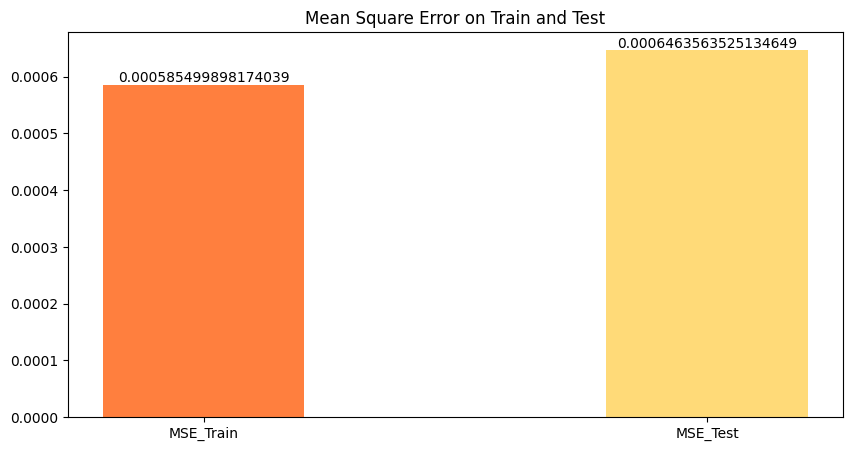

In [ ]:
model = PredictStockPrice(stockHVN_df)
model.train()
model.evaluate_on_test_train()

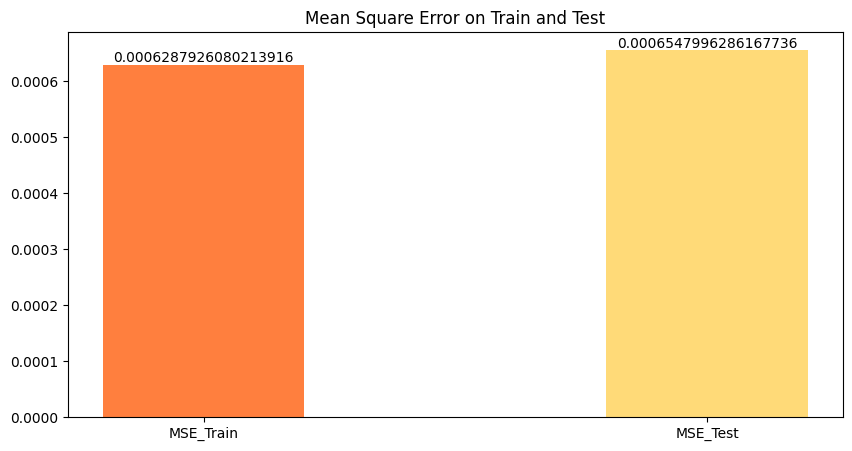

In [ ]:
# Least Absolute Shrinkage and Selection Operator (LASSO)
model.train(solver="normal", regParam=0.34, elasticNetParam = 1)
model.evaluate_on_test_train()

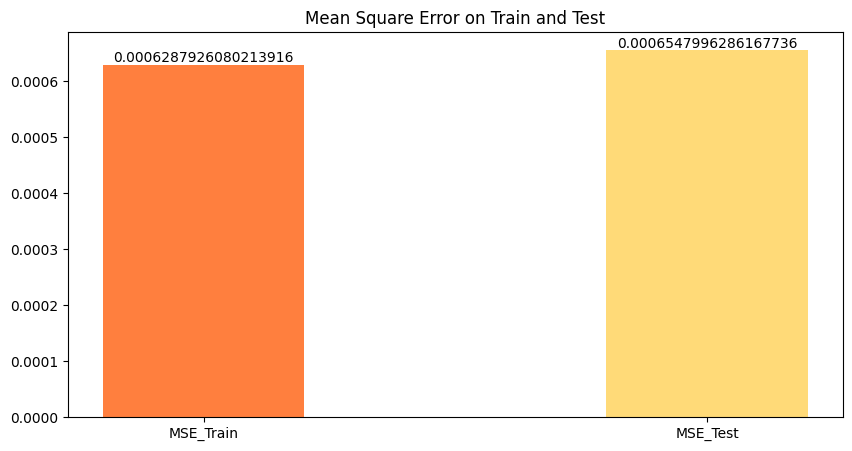

In [ ]:
# Elastic net
model.train(regParam=0.13, elasticNetParam = 0.23)
model.evaluate_on_test_train()

## Câu 5: Phân loại đa lớp với pyspark

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier, LinearSVC, OneVsRest, OneVsRestModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import rand

import numpy as np

In [ ]:
class MNISTrainer():
    def __init__(self, df: pyspark.sql.DataFrame):
        self.df = df
        self.__preprocessing()
        self.__split_df()

    def __preprocessing(self):
        # Define the input and output column names
        input_cols = self.df.columns[1:]  # Assuming the first column is the label
        output_col = self.df.columns[0]

        # Assemble the features into a single vector column
        assembler = VectorAssembler(inputCols=input_cols, outputCol="features")
        self.df = assembler.transform(self.df).select("features", "label")

    def __split_df(self):
        train, test = self.df.randomSplit(weights=[0.8,0.2], seed=200)
        self.train_df = train
        self.test_df = test

    def __plot_metrics(self, metrics, title = ""):
        model_names = list(metrics.keys())
        train_accuracy_values = [model_data["Train Accuracy"] for model_data in metrics.values()]
        test_accuracy_values = [model_data["Test Accuracy"] for model_data in metrics.values()]

        X_axis = np.arange(len(model_names))

        plt.bar(X_axis - 0.2, train_accuracy_values, 0.4, label = 'Train Accuracy')
        plt.bar(X_axis + 0.2, test_accuracy_values, 0.4, label = 'Test Accuracy')

        plt.xticks(X_axis, model_names)
        plt.xlabel("Models")
        plt.title("Accuracy of Models")
        plt.legend()
        plt.show()

    def __plot_predictions(self, predictions, title, num_samples=5):
        # Select a random sample of data
        sample_data = predictions.select("label", "prediction", "features")\
                                 .orderBy(rand())\
                                 .take(num_samples)

        # Plot the images with their predicted labels
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        fig.suptitle(title)

        for i, data in enumerate(sample_data):
            label = int(data.label)
            prediction = int(data.prediction)
            features = data.features

            # Reshape the features to the original image shape (28x28)
            image = np.array(features).reshape(28, 28)

            # Plot the image
            axes[i].imshow(image, cmap='gray')
            axes[i].set_title(f"Label: {label}, Predicted: {prediction}")
            axes[i].axis('off')

        plt.show()

    def __trainer(self, model, title = ""):
        model_name = str(model).split("_")[0]
        # train the model
        model = model.fit(self.train_df)

        pred_train = model.transform(self.train_df)
        pred_test = model.transform(self.test_df)

        evaluator_train = MulticlassClassificationEvaluator(metricName="accuracy")
        evaluator_test = MulticlassClassificationEvaluator(metricName="accuracy")

        acc_train = evaluator_train.evaluate(pred_train)
        acc_test = evaluator_test.evaluate(pred_test)
        if not isinstance(model, OneVsRestModel):
            eval_loss = MulticlassClassificationEvaluator(metricName="logLoss")
            loss_train = eval_loss.evaluate(pred_train)
            print(f"Cross-Entropy of {model_name} = " + str(loss_train))
        else:
            print(f"Cannot calc Cross-Entropy of {model_name}")

        self.__plot_predictions(pred_test, title)
        return acc_train, acc_test

    def run_multiple_model(self, models, names = []):
        result = dict()
        for idx, model in enumerate(models):
            loss, acc = self.__trainer(model, f"Predict sample on {names[idx]}")
            result[names[idx]] = {
                "Train Accuracy": loss,
                "Test Accuracy": acc
            }
        self.__plot_metrics(result, "Evaluate Multiple Model")




In [ ]:
# Define the structure for the data frame
column_names = [T.StructField('label', T.ByteType(), True)] + \
               [
                T.StructField(f'pixel_{i}', T.ShortType(), True)\
                for i in range(784)
               ]

mnist_schema = T.StructType(column_names)

# Load data from file with schema created
mnist_df = sparkSession.read.csv("/content/mnist_mini.csv", schema=mnist_schema)

# Show first few rows
mnist_df.show(5)

+-----+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---

Cross-Entropy of MultilayerPerceptronClassifier = 0.05635475526753959


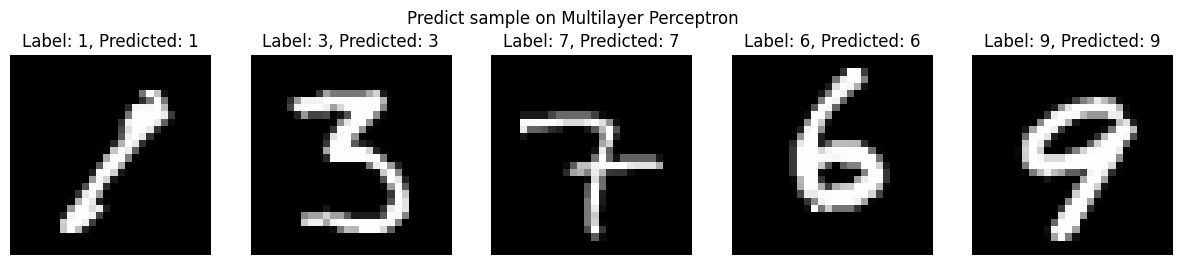

Cross-Entropy of RandomForestClassifier = 0.9396408684029868


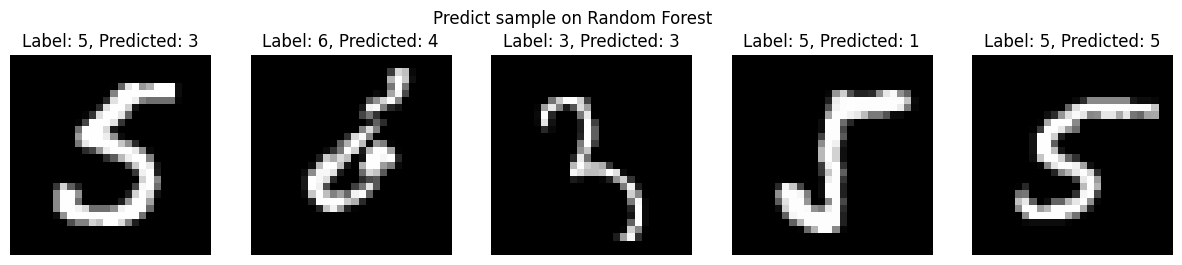

Cannot calc Cross-Entropy of OneVsRest


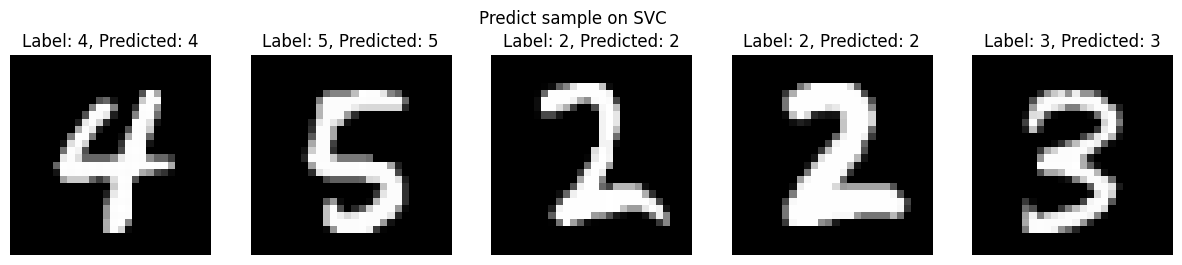

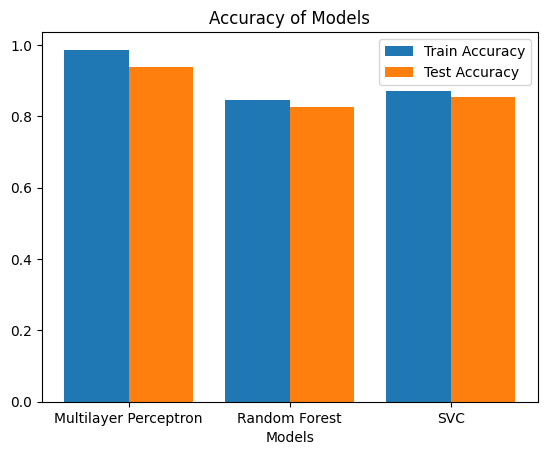

In [ ]:
fac = MNISTrainer(mnist_df)
mlp = MultilayerPerceptronClassifier(maxIter=100, layers=[784, 392, 64, 10], blockSize=128)
rf = RandomForestClassifier()

# Define the Linear SVC Classifier
svc = LinearSVC(maxIter=10, regParam=0.1)

# Define OneVsRest classifier
ovr = OneVsRest(classifier=svc)

all_models = [mlp, rf, ovr]
all_names = ["Multilayer Perceptron", "Random Forest", "SVC"]

fac.run_multiple_model(all_models, all_names)